<a href="https://colab.research.google.com/github/neSTORY/CartoonGAN_modified/blob/main/my_CartoonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=False)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# 경로 지정
root = "/gdrive/MyDrive/ugatit/dataset/fight"
%cd /gdrive/MyDrive/Colab Notebooks/cartoon_gan/Keras-CartoonGan

/gdrive/MyDrive/Colab Notebooks/cartoon_gan/Keras-CartoonGan


In [3]:
!pip install -U gast==0.2.2
!pip install h5py==2.10.0
!pip install tensorflow-addons # for using Instance Normalization

In [4]:
### import library ###

import os, glob, time, cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# modeling
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D,\
BatchNormalization, Activation, MaxPooling2D, Layer, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg19 import VGG19

# optimizer
from tensorflow.keras.optimizers import Adam

# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

tf.config.run_functions_eagerly(True)

In [6]:
# sample image
sample_img = root + "/my_test/박서준.jpg"

def preprocess(input):
    """
    # 전처리 과정
    1. [0, 255] -> [-1, 1]
    2. rgb => bgr
    """
    input = input[...,::-1] # rgb -> bgr
    input = input/127.5 -1 # -1~1
    return input

def load_net_in(img_fname=sample_img, output_size=256):
    input_img = Image.open(img_fname).convert("RGB")
    input_img = input_img.resize((output_size, output_size), Image.BICUBIC)
    input_img = np.asarray(input_img)

    # preprocess, (-1, 1)
    input_img = preprocess(input_img)
    return input_img

def postprocess(output):
    """
    # 후처리
    1. bgr -> rgb
    2. [-1,1] -> [0,1]
    """
    output = output[...,::-1] # bgr -> rgb
    output = output * 0.5 + 0.5 # [-1,1] -> [0,1]
    return output

### smooth dataset
기존 Gan은 애니메이션의 특징인 진한 외곽선을 추출하지 못 해서 가우시안 블러 처리가 된 이미지 데이터셋(카툰 이미지)를 미리 준비한다.

In [7]:
### Gaussian Blur 적용 ###
# 이 코드는 모델링 전 미리 데이터셋을 준비할 때 사용해야 한다.
# 출처 : https://github.com/penny4860/Keras-CartoonGan

def create_smooth_dataset(root, save):
    file_list = os.listdir(root)
    os.makedirs(save, exist_ok=True) # 저장 폴더 생성
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)
    for n, f in tqdm(enumerate(file_list)):
        rgb_img = cv2.imread(os.path.join(root, f))
        gray_img = cv2.imread(os.path.join(root, f), 0)
        rgb_img = cv2.resize(rgb_img, (256, 256))
        pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
        gray_img = cv2.resize(gray_img, (256, 256))
        edges = cv2.Canny(gray_img, 100, 200)
        dilation = cv2.dilate(edges, kernel)

        gauss_img = np.copy(rgb_img)
        idx = np.where(dilation != 0)
        for i in range(np.sum(dilation != 0)):
            gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
            gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
            gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

        cv2.imwrite(os.path.join(save, str(n) + '.jpg'), gauss_img)

In [8]:
# Reflection Padding
# 이 코드는 keras 공식문서를 참고했습니다.
# 출처 : https://keras.io/examples/generative/cyclegan/

class ReflectionPadding2D(Layer):
  def __init__(self, padding=(1,1), **kwargs):
    self.padding = tuple(padding)
    super(ReflectionPadding2D, self).__init__(**kwargs)

  def call(self, input_tensor, mask=None):
    padding_width, padding_height = self.padding
    padding_tensor = [
                      [0,0],
                      [padding_height, padding_height],
                      [padding_width, padding_width],
                      [0,0]
                     ]
    return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

# 초기값 설정(block method에서 사용)
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# CartoonGAN 원문에는 network의 block구성을 나열했지만 코드의 간결화를 위해
# residual block부분을 함수화 했습니다.
# residual block 메서드는 kears 공식문서를 참고했습니다.

def residual_block(
    x,
    activation = LeakyReLU(),
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=True,
    conv_num=4,
    inst_num=4,
):

    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
        name=f"conv{conv_num}_1", # 레이어 이름 용
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer,
                                         name=f"inst{inst_num}_1")(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
        name=f"conv{conv_num}_2",
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer,
                                         name=f"inst{inst_num}_2")(x)
    x = keras.layers.add([input_tensor, x])

    return x

In [9]:
### generator & discriminator ###
"""
CartoonGAN origin code에서는 InstanceNormalization을 정의해서
사용했지만(사실 이것도 keras에서 정의된 코드를 그대로 가져다 썼음)
이제는 tensorflow-addons에 메서드가 정의되어 있기 때문에 tfa에 있는
메서드를 사용했습니다.
"""

def generator(input_size=256):
  input_shape = [input_size,input_size,3] # resizing
  img_input = Input(shape=input_shape, name="input_image")
  
  # Block 1 : shape (256, 256, 3) => (256,256,64)
  x = ReflectionPadding2D(padding=(3,3))(img_input)
  x = Conv2D(64, (7,7), strides=1, use_bias=True, padding="valid", name="conv1")(x)
  x = tfa.layers.InstanceNormalization(name="inst1")(x)
  x = LeakyReLU(0.2)(x)

  # Block 2(downsample-1) : shape (256, 256, 64) => (128, 128, 128)
  x = Conv2D(128, (3,3), strides=2, use_bias=True, padding="same", name="conv2_1")(x)
  x = Conv2D(128, (3,3), strides=1, use_bias=True, padding="same", name="conv2_2")(x)
  x = tfa.layers.InstanceNormalization(name="inst2")(x)
  x = LeakyReLU(0.2)(x)

  # Block 3(downsample-2) : shape (128, 128, 128) => (64, 64, 256)
  x = Conv2D(256, (3,3), 2, use_bias=True, padding="same", name="conv3_1")(x)
  x = Conv2D(256, (3,3), 1, use_bias=True, padding="same", name="conv3_2")(x)
  x = tfa.layers.InstanceNormalization(name="inst3")(x)
  x = LeakyReLU(0.2)(x)

  # Residual Blocks(num : 8)
  # CycleGAN 과 구성이 똑같음
  residual_num = 8
  iter_num = 1
  for _ in range(residual_num):
    x = residual_block(x, conv_num=3+iter_num, inst_num=3+iter_num)
    iter_num +=1
  
  # Block 12(upsample-1) : shape (64, 64, 256) => (128, 128, 128)
  x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding="same", name="deconv1_1")(x)
  x = Conv2D(128, (3,3), strides=1, use_bias=True, padding="same", name="deconv1_2")(x)
  x = tfa.layers.InstanceNormalization(name="in_deconv1")(x)
  x = LeakyReLU(0.2)(x)
  
  # Block 13(upsample-2) : shape (128, 128, 128) => (256, 256, 64)
  x = tf.keras.layers.Conv2DTranspose(64, 3, 2, padding="same", name="deconv2_1")(x)
  x = Conv2D(64, (3, 3), strides=1, use_bias=True, padding="same", name="deconv2_2")(x)
  x = tfa.layers.InstanceNormalization(name="in_deconv2")(x)
  x = LeakyReLU(0.2)(x)

  # Block 14(upsample-3) : shape (256, 256, 64) => (256, 256, 3)
  x = ReflectionPadding2D(padding=(3,3))(x)
  x = Conv2D(3, (7,7), strides=1, use_bias=True, padding="valid", name="deconv3")(x)
  x = Activation("tanh")(x)

  model = Model(img_input, x, name="generator")
  return model

def discriminator(input_size=256):
  input_shape=[input_size, input_size, 3]
  img_input = Input(shape=input_shape, name="input")
  
  # Block 1 : shape (256, 256, 3) => (256, 256, 32)
  x = Conv2D(32, (3,3), strides=1, use_bias=True, padding="same", name="conv1")(img_input)
  x = LeakyReLU(0.2)(x)

  # Block 2 : shape (256, 256, 64) => (128, 128, 64)
  x = Conv2D(64, (3,3), strides=2, use_bias=True, padding="same", name="conv2_1")(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(64, (3,3), strides=1, use_bias=True, padding="same", name="conv2_2")(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = LeakyReLU(0.2)(x)

  # Block 3 : shape (128, 128, 64) => (64, 64, 256)
  x = Conv2D(128, (3,3), strides=2, use_bias=True, padding="same", name="conv3_1")(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(256, (3,3), strides=1, use_bias=True, padding="same", name="conv3_2")(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = LeakyReLU(0.2)(x)

  # Block 4 : shape (64, 64, 256) => (64, 64, 256)
  x = Conv2D(256, (3,3), strides=1, use_bias=True, padding="same", name="conv4")(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = LeakyReLU(0.2)(x)

  # Block 5 : shape (64, 64, 256) => (64, 64, 1)
  x = Conv2D(1, (3,3), strides=1, use_bias=True, padding="same", activation="sigmoid", name="conv5")(x)
  model = Model(img_input, x, name="discriminator")
  return model

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


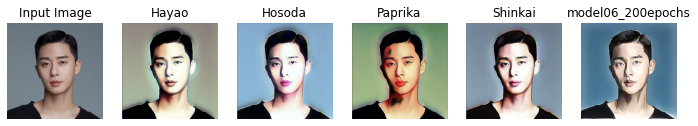

In [10]:
### 기존 모델로 sample image 테스트 ###
input_size = 512

# 1. 인물 이미지 변환 
# Cartoongan Test 
model_names = ["params/Hayao.h5", "params/Hosoda.h5", "params/Paprika.h5", "params/Shinkai.h5","my_model/model06_200epochs.h5"]
model = generator(input_size=input_size)

fig, ax = plt.subplots(figsize=(12,8))
plt.subplot(1, 6, 1)
plt.axis('off')
plt.title("Input Image")
plt.imshow(postprocess(load_net_in(sample_img)))

for i, model_path in enumerate(model_names):
    model.load_weights(model_path)

    imgs = np.expand_dims(load_net_in(sample_img, output_size=input_size), axis=0)
    ys = model.predict(imgs)
    y = postprocess(ys)[0]

    plt.subplot(1, 6, i+2)
    plt.axis('off')
    plt.title(os.path.basename(model_path).split(".")[0])
    plt.imshow(y)
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


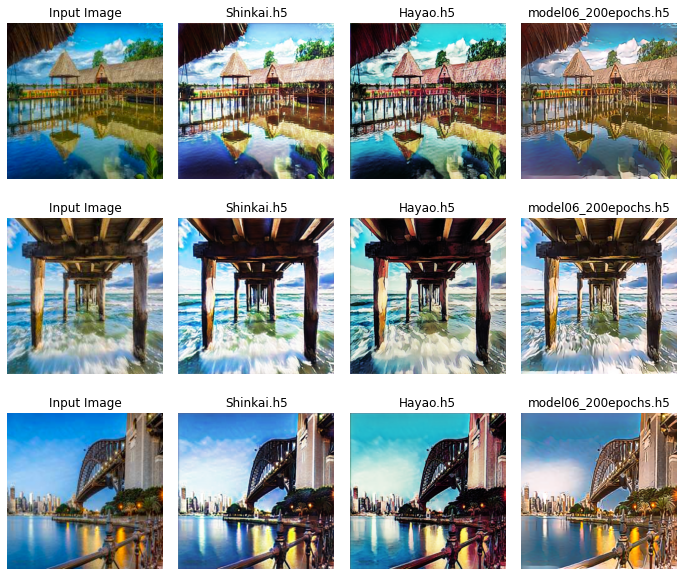

In [11]:
# Test 2
input_size = 512
img_files = ["sample_in/in1.png", "sample_in/in2.png", "sample_in/in3.png"]
model_names = ["params/Shinkai.h5", "params/Hayao.h5","my_model/model06_200epochs.h5"]
n_rows = 3
n_cols = 4

model = generator(input_size=input_size)

fig, ax = plt.subplots(figsize=(12, 8))
for i, fname in enumerate(img_files):
    plt.subplot(n_rows, n_cols, 4*i+1) # 1, 5, 9
    plt.axis('off')
    plt.title("Input Image")
    plt.imshow(postprocess(load_net_in(fname)))

    for j, model_path in enumerate(model_names):
        model.load_weights(model_path)
    
        imgs = np.expand_dims(load_net_in(fname, output_size=input_size), axis=0)
        ys = model.predict(imgs)
        y = postprocess(ys)[0]

        plt.subplot(n_rows, n_cols, 4*i+j+2) # 2, 6, 10 / 3, 7, 11/ 4, 8, 12
        plt.axis('off')
        plt.title(os.path.basename(model_path))
        plt.imshow(y)
plt.subplots_adjust(bottom = 0, top = 1, hspace = 0.05, wspace = 0.1)
plt.show()

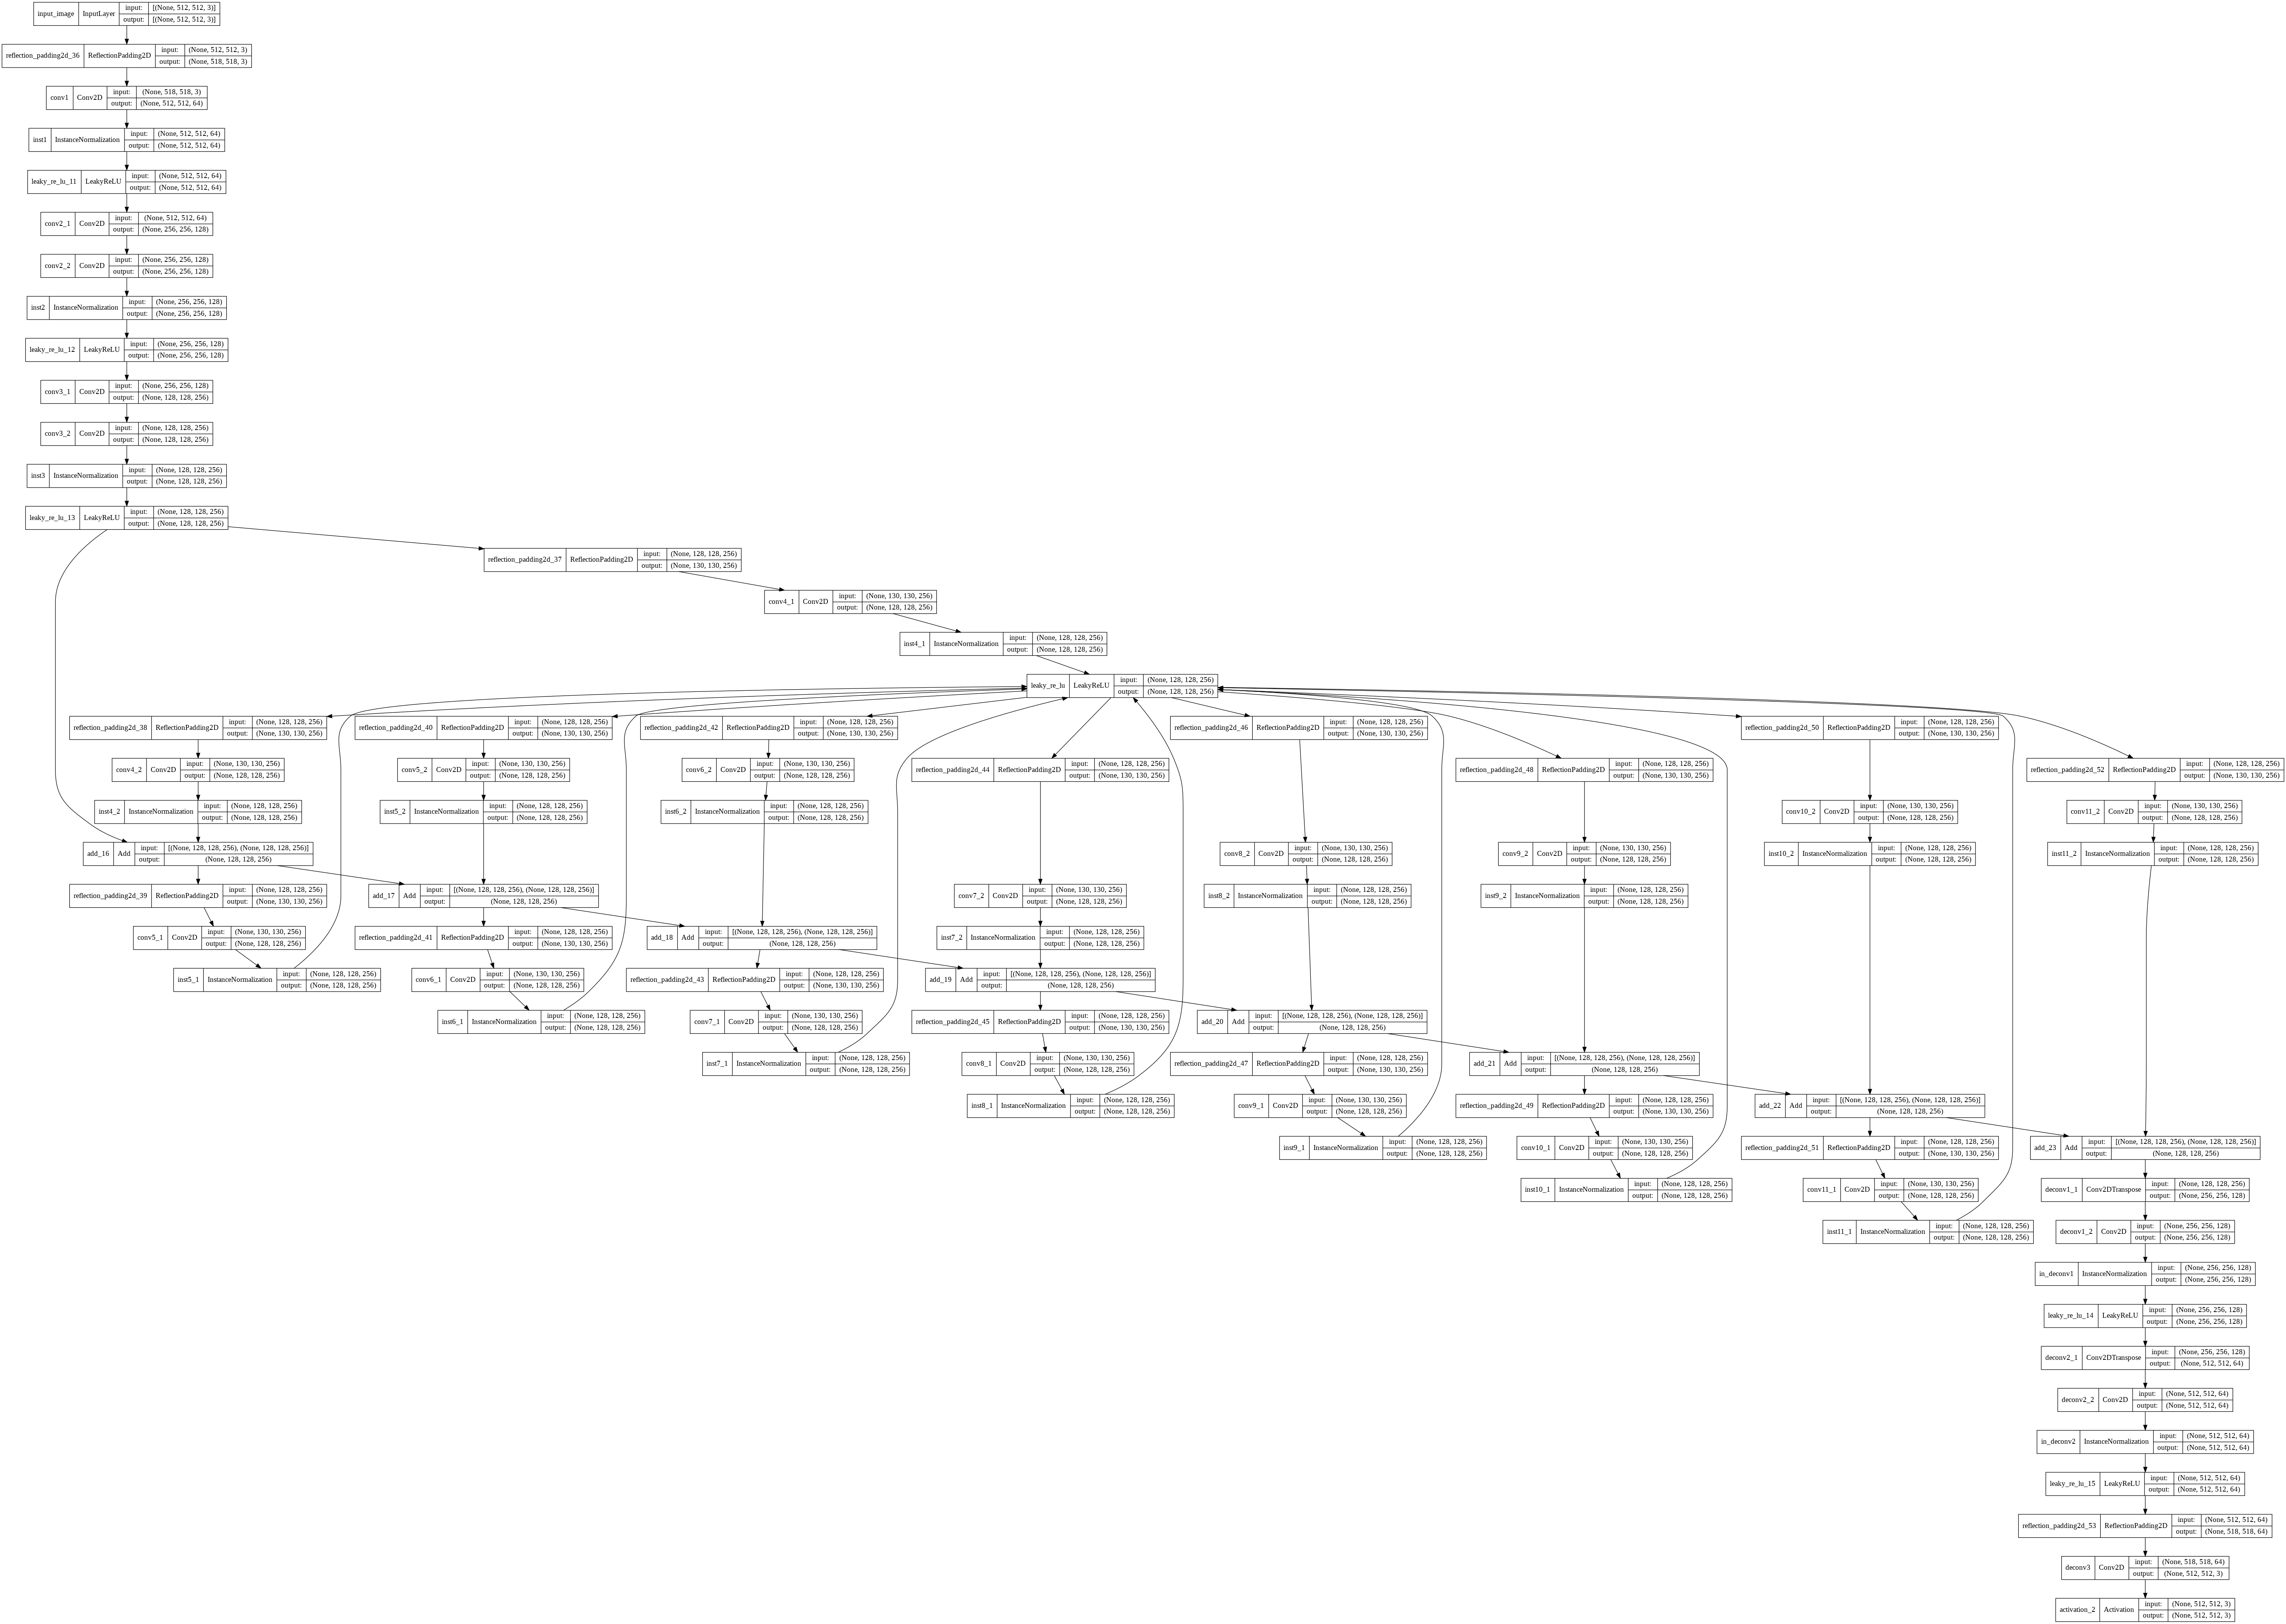

In [12]:
# generator network 시각화
from tensorflow.keras.utils import plot_model
model_g = generator(input_size=input_size)
plot_model(model_g, show_shapes=True, to_file="generator_model.png")

In [13]:
# generator summary
model_g.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d_36 (Refle  (None, 518, 518, 3)  0          ['input_image[0][0]']            
 ctionPadding2D)                                                                                  
                                                                                                  
 conv1 (Conv2D)                 (None, 512, 512, 64  9472        ['reflection_padding2d_36[0][0]']
                                )                                                         

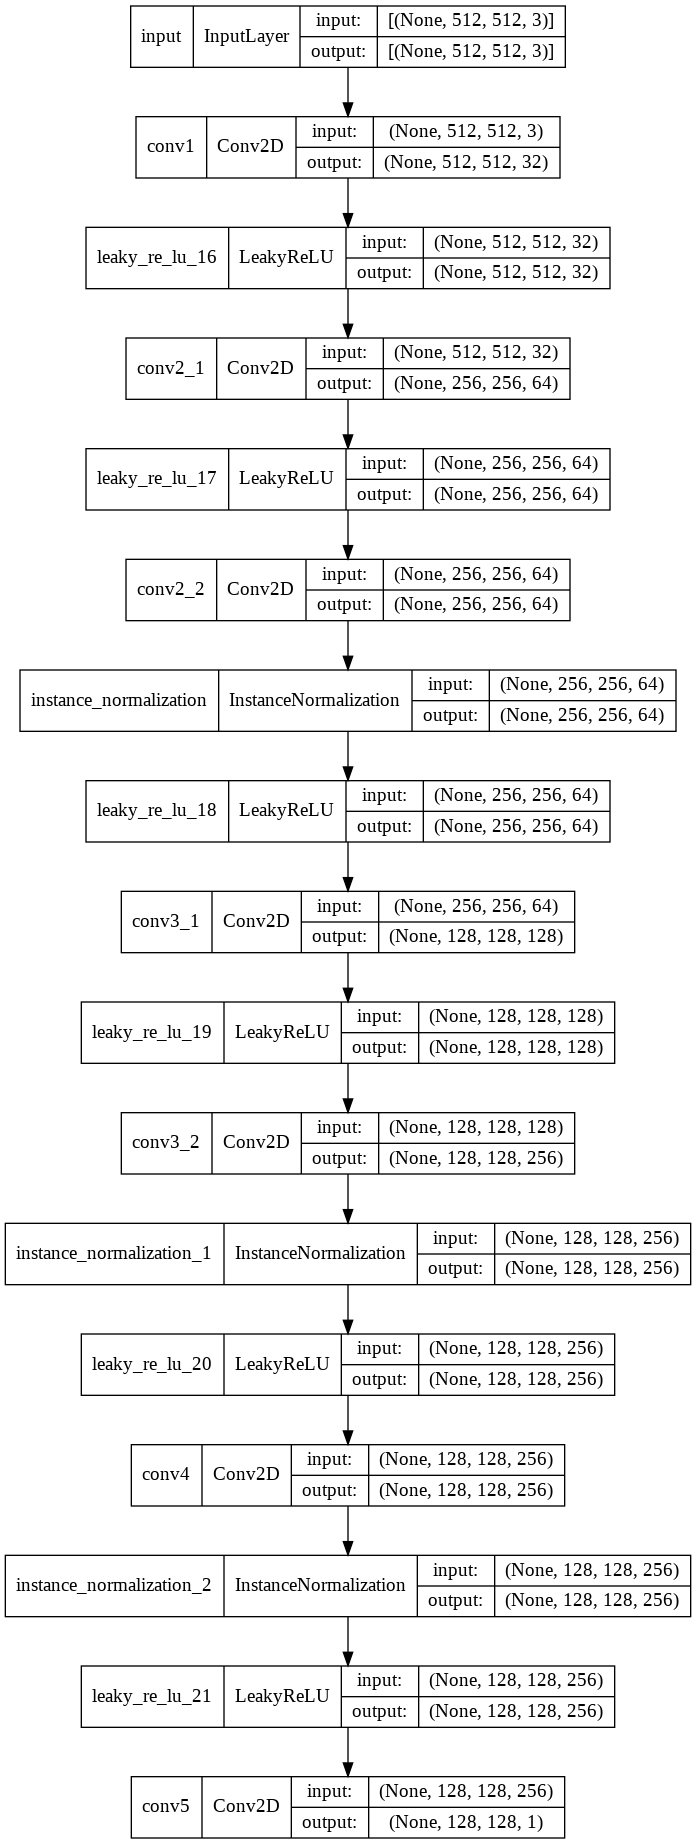

In [14]:
model_d = discriminator(input_size=input_size)
plot_model(model_d, show_shapes=True)

In [15]:
### Callbacks ###
def my_callbacks(saved_name="mobile_encoder.h5"):
  checkpoint = ModelCheckpoint(saved_name, monitor="val_loss",
                               verbose=1, save_best_only=True,
                               mode="min", period=1)
  callbacks = [checkpoint]
  callbacks.append(ReduceLROnPlateau(
      monitor="loss", factor=0.5,
      patience=10, verbose=1,
      mode="auto", min_delta= 1e-4,
      cooldown=0, min_lr = 1e-5
  ))
  return callbacks

In [16]:
### Batch Generator ###
# custom batch generator는 keras.utils의 Sequence를 상속받아야 한다.
# batch generator는 코드를 그대로 가져왔다.
# 그런데 origin 코드에서 IdenBatchGenerator 클래스에서 return 값이 xs를 두 개 받아온다.
# 설명용 주석도 잘못된 것 같고 아마 실수가 아닐까 싶다..

class BatchGenerator(Sequence):
    def __init__(self, fnames, batch_size, shuffle, label=0, input_size=256):
        self.fnames = fnames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_size = input_size
        self.label = label
        self.on_epoch_end()

    def __len__(self):
        return int(len(self.fnames) /self.batch_size)

    def __getitem__(self, idx):
        """
        # Args
            idx : batch index
        # Returns
            xs : (N, input_size, input_size, 3)
                rgb-ordered images
            ys : (N, input_size/4, input_size/4, 1)
        """
        batch_fnames = self.fnames[idx*self.batch_size: (idx+1)*self.batch_size]
        xs = [cv2.imread(fname)[:,:,::-1] for fname in batch_fnames]
        xs = np.array([cv2.resize(img, (self.input_size,self.input_size)) for img in xs])
        ys = self.label + np.zeros((self.batch_size,
                                    int(self.input_size/4),
                                    int(self.input_size/4),
                                    1))
        return xs, ys

    def on_epoch_end(self):
        np.random.shuffle(self.fnames)


class IdenBatchGenerator(Sequence):
    def __init__(self, fnames, batch_size, shuffle, input_size=256):
        self.fnames = fnames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_size = input_size
        self.on_epoch_end()

    def __len__(self):
        return int(len(self.fnames) /self.batch_size)

    def __getitem__(self, idx):
        """
        # Args
            idx : batch index
        # Returns
            xs : (N, input_size, input_size, 3)
                rgb-ordered images
            ys : (N, input_size/4, input_size/4, 1)
        """
        batch_fnames = self.fnames[idx*self.batch_size: (idx+1)*self.batch_size]
        xs = [cv2.imread(fname)[:,:,::-1] for fname in batch_fnames]
        xs = np.array([preprocess(cv2.resize(img, (self.input_size,self.input_size))) for img in xs])
        return xs, xs

    def on_epoch_end(self):
        np.random.shuffle(self.fnames)

# cartoon / edge-smoothing / photo
class CartoonBatchGenerator(Sequence):
    def __init__(self,
                 cartoon_fnames,
                 cartoon_smooth_fnames,
                 photo_fnames,
                 batch_size, input_size=256):
        self.cartoon_fnames = cartoon_fnames
        self.cartoon_smooth_fnames = cartoon_smooth_fnames
        self.photo_fnames = photo_fnames
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.on_epoch_end()

    def __len__(self):
        length = min(len(self.cartoon_fnames),
                     len(self.cartoon_smooth_fnames), 
                     len(self.photo_fnames))
        return int(length /self.batch_size)

    def __getitem__(self, idx):
        """
        # Args
            idx : batch index
        # Returns
            xs : (N, input_size, input_size, 3)
                rgb-ordered images
            ys : (N, input_size/4, input_size/4, 1)
        """
        def load(fnames):
            xs = [cv2.imread(fname)[:,:,::-1] for fname in fnames]
            xs = np.array([preprocess(cv2.resize(img, (self.input_size,self.input_size))) for img in xs])
            return xs
        batch_cartoon_fnames = self.cartoon_fnames[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_cartoon_smooth_fnames = self.cartoon_smooth_fnames[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_photo_fnames = self.photo_fnames[idx*self.batch_size: (idx+1)*self.batch_size]
        return load(batch_cartoon_fnames), load(batch_cartoon_smooth_fnames), load(batch_photo_fnames)

    def on_epoch_end(self):
        np.random.shuffle(self.cartoon_fnames)
        np.random.shuffle(self.cartoon_smooth_fnames)
        np.random.shuffle(self.photo_fnames)

In [20]:
class ResExtractor():

    def __init__(self, input_size=256, **kwargs):
        super(ResExtractor, self).__init__(**kwargs)
        self.input_size = input_size
        self.input_shape = [self.input_size, self.input_size, 3]
        self.img_input = tf.keras.layers.Input(shape=self.input_shape, name="input_img")

    def __call__(self):
        x = self.preprocessing()

        base_model = tf.keras.applications.ResNet101(weights="imagenet", include_top=False, input_shape=self.input_shape)
        model = Model(inputs=base_model.input, outputs=base_model.get_layer("conv4_block4_out").output)
        x = model(x)
        
        feat_model = Model(self.img_input, x, name="res_feat_extractor")
        feat_model.trainable = False
        
        # test msg
        # print("_"*50)
        # print("[completed] Feature extracting")
        # print("="*50)

        return feat_model
    
    def preprocessing(self):
        x = self.img_input
        x *= 255
        x -= tf.constant(np.array([103.939, 116.779, 123.68], dtype=np.float32)) # BGR의 평균값을 뺴줌

        # test msg
        # print("_"*50)
        # print("[completed] preprocessing input image")
        # print("="*50)

        return x

class PostPreprocess(keras.layers.Layer):

    def __init__(self, **kwargs):
        super(PostPreprocess, self).__init__(**kwargs)

    def call(self, x):
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0)
        x = x * 255
        return x

In [18]:
def g_loss_func(labels, predict):
    # generator loss function
    # 기존 GAN의 loss 대신 lsgan의 loss 구하는 방식을 사용(L2 norm)
    feat_model = ResExtractor()()
    labels_feat = feat_model(labels)
    predict_feat = feat_model(predict)
    res_contents_loss = tf.reduce_mean(tf.math.squared_difference(labels_feat, predict_feat))

    return res_contents_loss


class ModiCartoonGan():
    def __init__(self, pretrained_generator_fname="/gdrive/MyDrive/Colab Notebooks/cartoon_gan/Keras-CartoonGan/my_model/model06_200epochs.h5"):
        input_size = 256

        self.img_shape = (input_size, input_size, 3)
        optimizer = tf.keras.optimizers.Adam(lr=3e-4)

        # Build and compile the discriminator
        self.discriminator = discriminator(input_size)
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer)

        # Build the generator
        self.generator = generator(input_size)
        self.generator.load_weights(pretrained_generator_fname)

        # The generator takes noise as input and generates imgs
        p_tensor = Input(shape=self.img_shape)
        generated_catroon_tensor = self.generator(p_tensor)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_catroon_tensor)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        # D(G(x))
        self.discriminator_generator = Model(p_tensor,
                                             outputs=[generated_catroon_tensor, validity])
        self.discriminator_generator.compile(loss=[g_loss_func, 'binary_crossentropy'],
                                             loss_weights=[10.0, 1.0], # 논문에서 권장한 weight 초기값 10
                                             optimizer=optimizer)

    def train(self, batch_generator, sample_fname, epochs=1):
        # Adversarial loss ground truths
        valid = np.ones((batch_generator.batch_size,) + (64,64,1))
        fake = np.zeros((batch_generator.batch_size,) + (64,64,1))

        for epoch in range(epochs):
          start = time.time()
          for batch_i, (cartoon_imgs, cartoon_smooth_imgs, photo_imgs) in enumerate(batch_generator):
          
              #  Train Discriminators
              gen_cartoon_imgs = self.generator.predict(photo_imgs)
          
              d_loss_real = self.discriminator.train_on_batch(cartoon_imgs, valid)
              # Adversarial Loss 를 사용하여 학습했을때 생성된 이미지의 가장자리 선(edge) 이 뚜렷하지 않다는 점
              # 이러한 이미지를 입력 받았을때 0을 아웃풋 하도록 함.
              d_loss_smooth = self.discriminator.train_on_batch(cartoon_smooth_imgs, fake)
              d_loss_fake = self.discriminator.train_on_batch(gen_cartoon_imgs, fake)
              
              # total loss 
              d_loss = (d_loss_real + d_loss_smooth + d_loss_fake) / 3
          
              #  Train Generators
              g_loss = self.discriminator_generator.train_on_batch(photo_imgs,
                                                                  [photo_imgs, valid]) 
              
              if batch_i % 10==0:
                print("{}-th step, d_loss: {}, g_loss: {}".format(batch_i, d_loss, g_loss))
              
          self.generator.save_weights("./my_model/model06_{}epochs.h5".format(epoch+1))
          end = time.time()
          print("{}-th epoch, d_loss: {}, g_loss: {}".format(epoch, d_loss, g_loss))
          print(f"{epoch} epoch 진행 시간 : {end-start}s 입니다.")
          self.sample_images(epoch, sample_fname)
          
                

    def sample_images(self, epoch, sample_fname):
        os.makedirs('generated_imgs', exist_ok=True)
        img = cv2.resize(cv2.imread(sample_fname)[:,:,::-1], (256,256))
        imgs = preprocess(np.expand_dims(img, axis=0))
        gen_imgs = self.generator.predict(imgs)
        gen_img = postprocess(gen_imgs)[0]

        fig, ax = plt.subplots()
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title("input photo")
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.title("cartoonized")
        plt.imshow(gen_img)
        fig.savefig("generated_imgs/1206_{}.jpg".format(epoch))
        plt.show()

In [22]:
# CartoonGan Train 

root = "/gdrive/MyDrive/ugatit/dataset/fight"

# photo_fnames = glob.glob(root + "/photo/*.*")
photo_fnames = glob.glob(root+"/trainA_re/*.*")

# cartoon_fnames = glob.glob(root + "/cartoon/*.*")
cartoon_fnames = glob.glob(root + "/trainB_re/*.*")

cartoon_smooth_fnames = glob.glob(root + "/trainB_smooth_re/*.*")

print(len(photo_fnames), len(cartoon_fnames), len(cartoon_smooth_fnames))

batch_generator = CartoonBatchGenerator(cartoon_fnames, cartoon_smooth_fnames, photo_fnames, batch_size=8)
# batch_size가 32 이상이면 OOM 발생.. 아쉽지만 8로 하자..

gan = ModiCartoonGan()
gan.train(batch_generator, sample_fname=photo_fnames[0])